### Solving a QUBO problem using the QAOA Algorithm


In [1]:
from qiskit import *
from qiskit.circuit import Parameter 
import numpy as np
%matplotlib inline
import random

In [18]:
def create_circuit(theta, variables, permutations): 
    """
    ---- Arguments
    theta (list): a set of angles that'll work as parametes 
    variables (dictionary): the existence variables of the qubo problem
    permutations (dictionary): all the permutations of the variables related to the problem

    """
    num_qubits=len(variables)
    thetas=np.array(theta) 
    p=thetas.size//2 

    circuit=QuantumCircuit(num_qubits)

    betta=theta[:p]
    gamma=theta[p:] 

    for i in range(0, num_qubits): #Create the initial superposition 
        circuit.h(i) 

    
    for irep in range(0,p):
        
        for i in range(0,num_qubits): ## Adds the Problem Unitary 
            circuit.rz(gamma[irep],i) 
            circuit.barrier()
        
        for n in permutations: ## Adds the Problem Unitary 
            circuit.rzz(2*gamma[irep],n[0],n[1]) 
            circuit.barrier() 
        
        for i in range(0,num_qubits): #Apply the mixer operator
            circuit.rx(2*betta[irep],i)
        
        

    circuit.measure_all()
    return circuit 


def compute_expectation_value(counts,f):
    
    avg=0
    sum_count=0 
    Values=[]
    list=[]

    def problem_function(Values, f): 
        return f(Values[0][0],Values[0][1],Values[0][2],Values[0][3])

    for result,count in counts.items(): 
    
        list.append(result)

        for i in range(len(list)):
            Values.append([int(k) for k in list[i]])

        obj = problem_function(Values,f) 
        avg += obj * count
        sum_count += count
    
    return avg/sum_count 


def get_expectation(f,variables, permutations, shots=512):

    backend=Aer.get_backend('qasm_simulator')
    backend.shots=shots

    def run_circuit(theta):
        circuit= create_circuit(theta,variables, permutations)
        counts=backend.run(circuit, seed_simulator=10, nshots=shots).result().get_counts() 
        
        return compute_expectation_value(counts, f)
    
    return run_circuit



In [32]:
from scipy.optimize import minimize, slsqp


def f(x1,x2,x3,x4): 
    return -x1**2-x2**2-x3**2-x4**2 + 6*(x1*x3+x1*x4+x3*x4+x1*x2) 


variables={'x1','x2','x3','x4'}
permutations={(0,2),(0,3),(2,3),(0,1)}
initial=[random.uniform(0, 2*np.pi) for i in range(2)] 

expectation= get_expectation(f,variables, permutations)


res=minimize(expectation, initial, method='slsqp', tol=1e-6) 

print(res)

     fun: -1.0
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.08664487, 1.49806053])


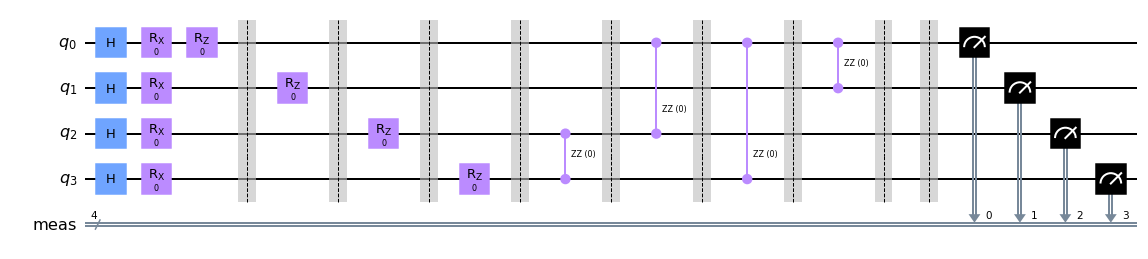

In [13]:
from qiskit.visualization import plot_histogram 

backend= Aer.get_backend("aer_simulator")
backend_shots=512 
theta=[0., 0.]
qc_res= create_circuit(theta, variables, permutations)

counts=backend.run(qc_res,seed_simulator=10).result().get_counts()

#plot_histogram(counts,figsize=(15,12)) 
qc_res.draw(output='mpl')

